In [1]:
# -----------------------------------------------------------------------------
# Visualising cross-validated evaluation results for multiple DCM sizes and
#   1. A 2 × 2 grid of heat-maps (one per target class cardinality), where the
#      colour encodes the mean cross-validated accuracy and each cell is a
#      (model × DCM-size) combination.
#   2. A grouped bar-chart that shows for every model × DCM size combination 
#      the mean accuracy together with its standard deviation across folds,
#      split by target cardinality.
# -----------------------------------------------------------------------------
import Pkg
Pkg.activate(".")
Pkg.update("CategoricalArrays")
Pkg.add(["CSV", "DataFrames", "StatsPlots", "Glob", "Statistics", "CategoricalArrays", "Plots", "Measures"])

using CSV, DataFrames, StatsPlots, Glob, Statistics, CategoricalArrays, Plots, Measures



  Activating project at `~/Python_C_ML/Translational Neuromodeling/Project/Project_8/Classification_and_Regression_DCM`
    Updating registry at `~/.julia/registries/General.toml`
  No Changes to `~/Python_C_ML/Translational Neuromodeling/Project/Project_8/Classification_and_Regression_DCM/Project.toml`
  No Changes to `~/Python_C_ML/Translational Neuromodeling/Project/Project_8/Classification_and_Regression_DCM/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Python_C_ML/Translational Neuromodeling/Project/Project_8/Classification_and_Regression_DCM/Project.toml`
  No Changes to `~/Python_C_ML/Translational Neuromodeling/Project/Project_8/Classification_and_Regression_DCM/Manifest.toml`


Using data directory: /Users/ricobenning/Python_C_ML/Translational Neuromodeling/Project/Project_8/Classification_and_Regression_DCM/data
Found 9 evaluation CSVs:
  • 11x11_evaluation_results_logistic.csv
  • 11x11_evaluation_results_multinomial.csv
  • 11x11_evaluation_results_random_forest.csv
  • 15x15_evaluation_results_logistic.csv
  • 15x15_evaluation_results_multinomial.csv
  • 15x15_evaluation_results_random_forest.csv
  • 4x4_evaluation_results_logistic.csv
  • 4x4_evaluation_results_multinomial.csv
  • 4x4_evaluation_results_random_forest.csv
Loaded 108 evaluation rows from 9 files.
Creating heat-maps …
Creating grouped bar-charts …


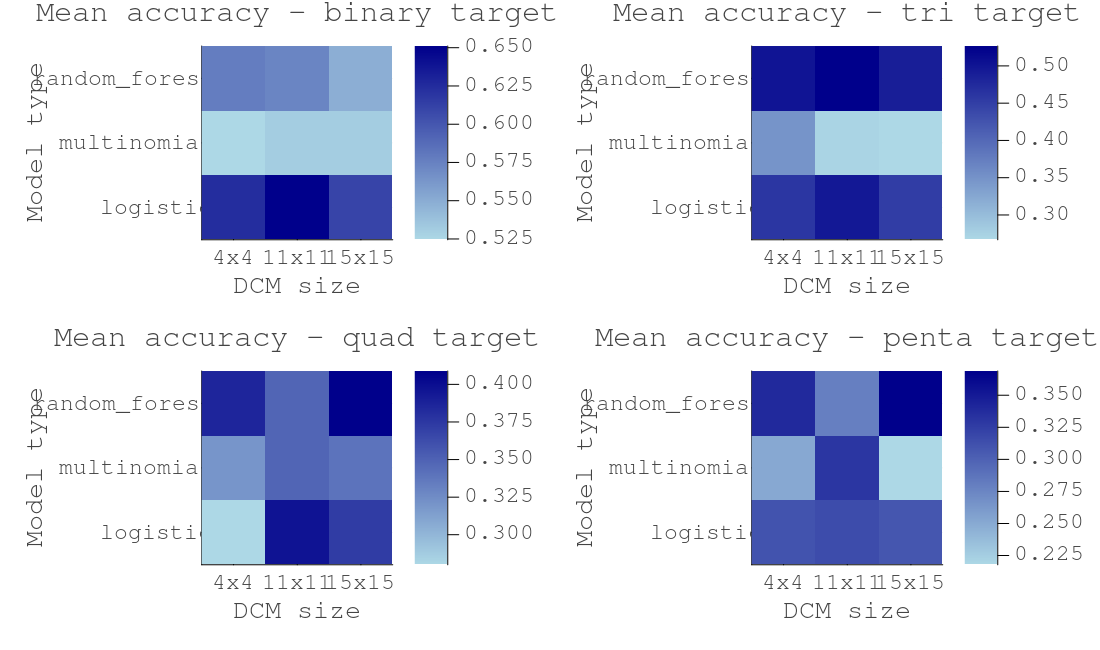

GKS: could not find font sans.ttf


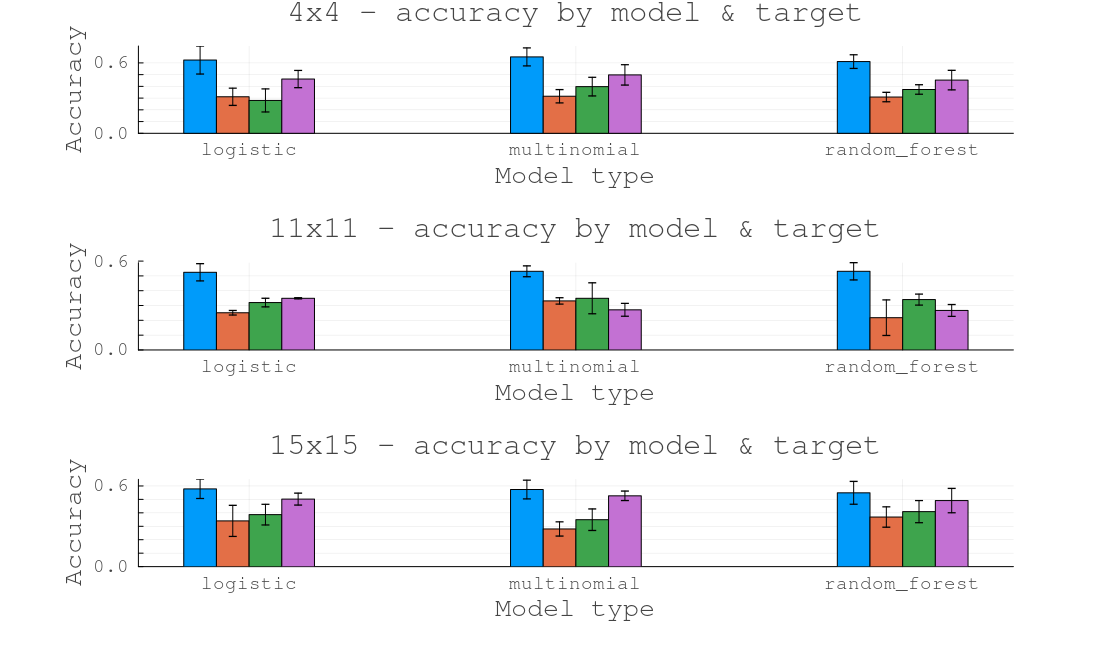

Done!  Figures written to the working directory.


In [ ]:

theme(:default)
default(size  = (1100, 650),        
        fontfamily = "sans")

# Directory that contains the nine CSV files.
# Change to your own path!
const DATA_DIR = "/Users/ricobenning/Python_C_ML/Translational Neuromodeling/Project/Project_8/Classification_and_Regression_DCM/permutation_results" 

println("Using data directory: $(DATA_DIR)")

# Expected file name e.g. 4x4_evaluation_results_logistic.csv
PATTERN = r"^(\d+x\d+)_evaluation_results_(logistic|multinomial|random_forest)\.csv$"

# gather legitimate CSVs, drop hidden & AppleDouble files -----------------
all_entries = readdir(DATA_DIR; join = true)
files = filter(all_entries) do f
    name = basename(f)
    startswith(name, ".")            && return false  # dot‑files + AppleDouble
    isnothing(match(PATTERN, name))   && return false  # must follow convention...
    return true
end

println("Found $(length(files)) evaluation CSVs:")
foreach(f -> println("  • ", basename(f)), files)

isempty(files) && error("No evaluation CSV files found in $(DATA_DIR).")


function parse_filename(path::AbstractString)
    fname = basename(path)
    m = match(PATTERN, fname)
    m === nothing && error("File '$(fname)' does not match expected naming convention.")
    return m.captures[1], m.captures[2]  # (dcm_size, model_type)
end

# Read and concatenate all CSV files into a single DataFrame
full_df = DataFrame()
for file in files
    dcm_size, model_type = parse_filename(file)
    df = CSV.read(file, DataFrame)
    df.DCM_size   = fill(dcm_size, nrow(df))
    df.model_type = fill(model_type, nrow(df))
    append!(full_df, df)
end

#categorical!(full_df, [:DCM_size, :model_type, :target]) did somehow not work... suspect old version
full_df.DCM_size   = categorical(full_df.DCM_size)
full_df.model_type = categorical(full_df.model_type)
full_df.target     = categorical(full_df.target)


# Aggregate the data to get mean and std accuracy per DCM size, model type, and target
agg = combine(groupby(full_df, [:DCM_size, :model_type, :target]),
              :perm_observed_accuracy => mean => :mean_acc,
              :perm_observed_accuracy => std  => :std_acc,
              :perm_null_mean_accuracy => mean => :mean_null)


# Heatmaps
function make_heatmaps(agg::DataFrame; savepath::AbstractString = "mean_accuracy_heatmaps.png")
    targets = ["binary", "tri", "quad", "penta"]
    dcm_levels = ["4x4", "11x11", "15x15"]
    model_levels = levels(agg.model_type)

    plots = Plots.Plot[]
    for tgt in targets
        sub = filter(:target => ==(tgt), agg)
        mat = [begin
           vals = sub[(sub.model_type .== mdl) .& (sub.DCM_size .== dcm), :mean_acc]
           isempty(vals) ? NaN : first(vals)
       end
       for mdl in model_levels, dcm in dcm_levels]
        p = heatmap(dcm_levels, model_levels, mat';
                    xlabel = "DCM size",
                    ylabel = "Model type",
                    c = :blues,
                    title = "Mean accuracy - $(tgt) target",
                    guidefontsize = 14,
                    tickfontsize = 12,
                    titlefontsize = 16)
        push!(plots, p)
    end

    fig = plot(plots...; layout = (2, 2), legend = false, left_margin = 10mm,
               bottom_margin = 10mm, top_margin = 5mm, right_margin = 10mm,
               subplot_padding = 1mm,)
    savefig(fig, savepath)
    display(fig)
end

# Grouped bar-charts
function make_grouped_bars(agg::DataFrame; savepath::AbstractString = "grouped_accuracy_bar.png")
    dcm_levels = ["4x4", "11x11", "15x15"]

    plots = Plots.Plot[]

    for dcm in dcm_levels
        sub = filter(:DCM_size => ==(dcm), agg)
        p = @df sub groupedbar(:model_type, :mean_acc,
                                group = :target,
                                yerror = :std_acc,
                                bar_position = :dodge,
                                bar_width = 0.4,
                                xlabel = "Model type",
                                ylabel = "Accuracy",
                                title = "$(dcm) - accuracy by model & target",
                                guidefontsize = 14,
                                tickfontsize = 10,
                                titlefontsize = 16,
                                yticks = ([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                                 ["0.0", "", "", "", "", "", "0.6"])
        )
        push!(plots, p)
    end


    fig = plot(plots...; 
               layout = (length(plots), 1), 
               legend = false,
               left_margin = 20mm,
               bottom_margin = 10mm,
               top_margin = 5mm,
               right_margin = 20mm)
    savefig(fig, savepath)
    display(fig)
end

############################################################
# 6.  RUN EVERYTHING                                        #
############################################################

function main()
    println("Loaded $(nrow(full_df)) evaluation rows from $(length(files)) files.")
    println("Creating heat-maps …")
    make_heatmaps(agg)

    println("Creating grouped bar-charts …")
    make_grouped_bars(agg)

    println("Done!  Figures written to the working directory.")
end

main()